In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob
import vaex
from hammer import dddm
root_dir = abspath(join('..', '..'))
data_dir = join(root_dir, 'Data') 
sys.path.append(root_dir)
from utils import (plot_corner, plot_chain, plot_fit, style, calculate_probs, get_params, get_initial_position_normal)

In [2]:
style()

In [3]:
zfiles = glob(join(root_dir, 'Data', 'Effective-Volume-no', 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_dir, 'Data', 'Velocity-Distribution-no', 'w*.hdf5'))
wfiles.sort()
zfiles, wfiles

(['/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(-0.10)_(0.10).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.10)_(0.16).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.16)_(0.20).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.20)_(0.23).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.23)_(0.26).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.26)_(0.28).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.28)_(0.30).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.30)_(0.32).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.32)_(0.34).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.34)_(0.36).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.36)_(0.37).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Effective-Volume-no/z_(0.37)_(0.39).hdf5',
  '

In [4]:
index = 0
zfile = zfiles[index]
wfile = wfiles[index]
zdata = vaex.open(zfile)
zmid = zdata['zmid'].to_numpy()
znum = zdata['znum'].to_numpy()
zerr = zdata['zerr'].to_numpy()

wdata = vaex.open(wfile)
wmid = wdata['wmid'].to_numpy()
wnum = wdata['wnum'].to_numpy()
werr = wdata['werr'].to_numpy()

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [5]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = [
    0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,
    0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015
]
sigmaz = [
    3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 
    18.0, 18.5, 18.5, 20.0, 20.0]
rhoDM = [0.016]
sigmaDD = [7]
hDD = [30]
log_nu0 = [0]
R = [3.4E-3]
zsun = [0]
w0 = [-7.]
sigma1 = 5.
sigma2 = 10.
log_sigmaw = [np.log(sigma1)]
q_sigmaw = [sigma1/sigma2]
a1 = 0.9
a2 = 0.1
log_a = [np.log(a1)]
q_a = [a2/a1]

theta = np.array([rhob + sigmaz + rhoDM + sigmaDD + hDD + log_nu0 + R + zsun + w0 + log_sigmaw + q_sigmaw + log_a + q_a]).flatten()
theta.shape

(35,)

In [6]:
locs_raw = dict(
    rhoDM=-0.05,
    sigmaDD=0.,
    hDD=1,
    log_nu0=-1,
    R=3.4E-3,
    zsun=-100,
    w0=-15,
    log_sigmaw=np.log(1),
    q_sigmaw=0.,
    log_a=np.log(0.01),
    q_a=0.,
)

scales_raw = dict(
    rhoDM=0.15,
    sigmaDD=30,
    hDD=1000,
    log_nu0=3,
    R=0.6E-3,
    zsun=200,
    w0=15,
    log_sigmaw=np.log(50)-locs_raw['log_sigmaw'],
    q_sigmaw=1.,
    log_a=np.log(100)-locs_raw['log_a'],
    q_a=1.0
)

keys = list(locs_raw.keys())
locs = np.array(list(locs_raw.values()))
scales = np.array(list(scales_raw.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('rhoDM', -0.05, 0.016, 0.09999999999999999),
 ('sigmaDD', 0.0, 7.0, 30.0),
 ('hDD', 1.0, 30.0, 1001.0),
 ('log_nu0', -1.0, 0.0, 2.0),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -100.0, 0.0, 100.0),
 ('w0', -15.0, -7.0, 0.0),
 ('log_sigmaw', 0.0, 1.6094379124341003, 3.912023005428146),
 ('q_sigmaw', 0.0, 0.5, 1.0),
 ('log_a', -4.605170185988091, -0.10536051565782628, 4.605170185988093),
 ('q_a', 0.0, 0.11111111111111112, 1.0)]

In [7]:
ndim = len(locs)+24
nwalkers = 10*ndim+2
ndim, nwalkers

(35, 352)

In [8]:
p0 = dddm.generate_p0(nwalkers, locs, scales)
p0.shape

(352, 35)

In [9]:
for p in p0:
    print(dddm.log_prob(p, zdata, wdata, locs, scales))

(38.05693370478974, -185051.90437537184)
(37.477373500292195, -636.6424847287736)
(34.231510800755835, -9806.616817467093)
(36.28903595589661, -86891515.28466125)
(35.49909945598398, -519230.7763712221)
(34.506327348979106, -7094.013097406453)
(28.354441862550704, -346934.09360229294)
(33.40673571703985, -39542806.86119464)
(37.190732340978904, -245703.64293431782)
(32.31511611296453, -439.61856038861043)
(38.52014927636334, -11822.580771794954)
(33.60391902956922, -782.9654032997855)
(36.831518629319014, -20175.980025840352)
(39.43863434147604, -143652.83244069957)
(38.31370282610509, -11205053.448073445)
(35.34898154594505, -14940547.386169333)
(34.718560324998116, -10342475.791933456)
(31.993833918482796, -18000.742595330285)
(36.05030187548017, -6085851.536765965)
(36.43457302689431, -2513356.9921572604)
(35.92109461400753, -51480.58549705492)
(33.84695039909264, -5415.391649803983)
(32.903657905720806, -335774207.60949475)
(30.212394761697052, -147179.37613228848)
(37.831035956973

In [10]:
p0_flat = p0.reshape(-1, ndim)
dddm.log_prob_par(p0_flat, zdata, wdata, locs, scales)

array([[ 3.80569337e+01, -1.85089961e+05, -1.85051904e+05],
       [ 3.74773735e+01, -6.74119858e+02, -6.36642485e+02],
       [ 3.42315108e+01, -9.84084833e+03, -9.80661682e+03],
       ...,
       [ 3.66757541e+01, -1.77097405e+05, -1.77060729e+05],
       [ 3.64489001e+01, -4.73337436e+04, -4.72972947e+04],
       [ 3.28308950e+01, -1.19810661e+03, -1.16527572e+03]])

(35,)


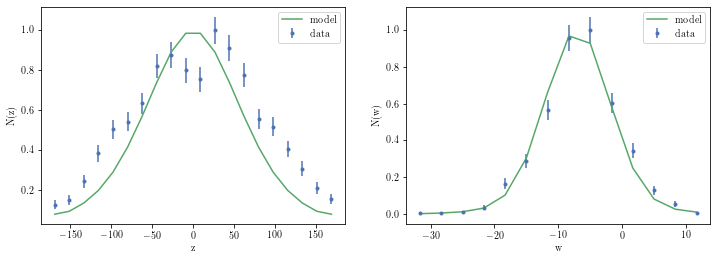

(46.89069775735642, 9.578595232260355)

In [11]:
print(theta.shape)
zmod = dddm.fz(zmid, theta)
wmod = dddm.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
dddm.log_prob(theta, zdata, wdata, locs, scales)

In [12]:
time0 = time()
for i in range(3):
    print("\t",i)
    t0 = time()
    chain = dddm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    burn = 300
    keys, locs_normal, scales_normal = get_initial_position_normal(keys, chain[burn:], np.arange(24, 24+len(keys)))
    p0 = dddm.generate_p0(nwalkers, locs_normal, scales_normal, norm=True)
    t0 = time()
    chain = dddm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
    print(time() - t0, "s")
    p0 = chain[-1]
print("total", time() - time0, "s")

	 0
15.071597337722778 s
14.262461185455322 s
	 1
14.13113808631897 s
14.530503511428833 s
	 2
14.39284062385559 s
14.666906118392944 s
total 87.18923211097717 s


In [13]:
calculate_probs(dddm, chain, ndim, zdata, wdata, locs, scales, batch=100)

array([[34.46783905, 65.17613596, 99.64397502],
       [37.23378576, 60.68318914, 97.9169749 ],
       [32.11679949, 26.8958055 , 59.01260499],
       ...,
       [36.31298024, 63.08896793, 99.40194817],
       [25.91408718, 65.4199706 , 91.33405778],
       [24.89834395, 64.25999541, 89.15833936]])

12it [00:01,  6.02it/s]


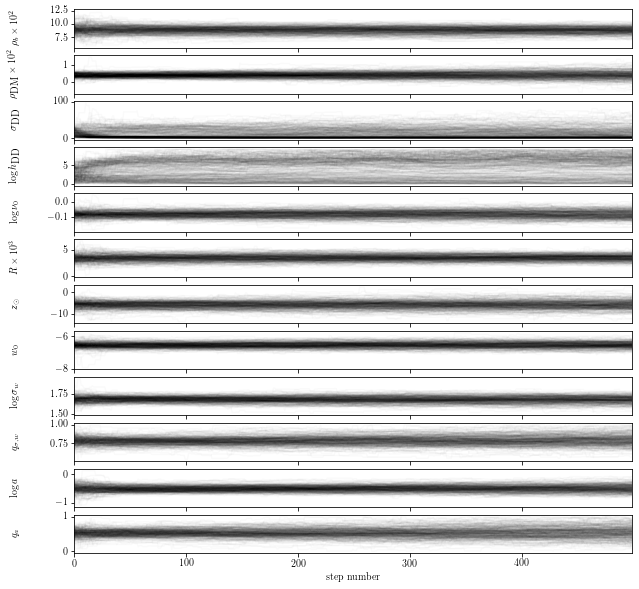

In [28]:
# labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\sigma_{\textup{DD}}$',
#           r'$\log h_{\textup{DD}}$', r'$\log \nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
#           r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
# labs = ['rhob', 'rhoDM', 'sigmaDD', 'log_hDD', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 
#         'q_sigmaw', 'log_a', 'q_a']
# indexes = [12] + list(range(24, len(labs)+23))

# params = get_params(chain, indexes, labs)
# plot_chain(params, labels, figsize=(10,10), alpha=0.02)

12it [00:01,  6.85it/s]


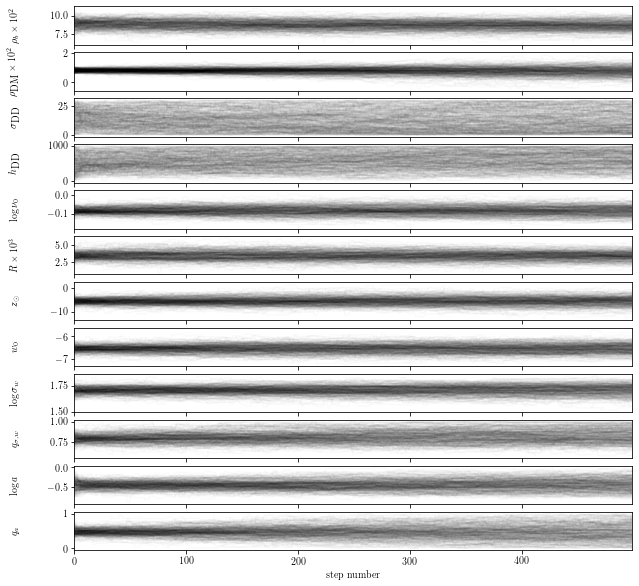

In [13]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\sigma_{\textup{DD}}$',
          r'$h_{\textup{DD}}$', r'$\log \nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'sigmaDD', 'hDD', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 
        'q_sigmaw', 'log_a', 'q_a']
indexes = [12] + list(range(24, len(labs)+23))

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

### long

In [14]:
p0_next = chain[-1]
t0 = time()
chain = dddm.mcmc(2200, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

62.05984950065613 s


(2200, 352, 35)

12it [00:01,  7.77it/s]


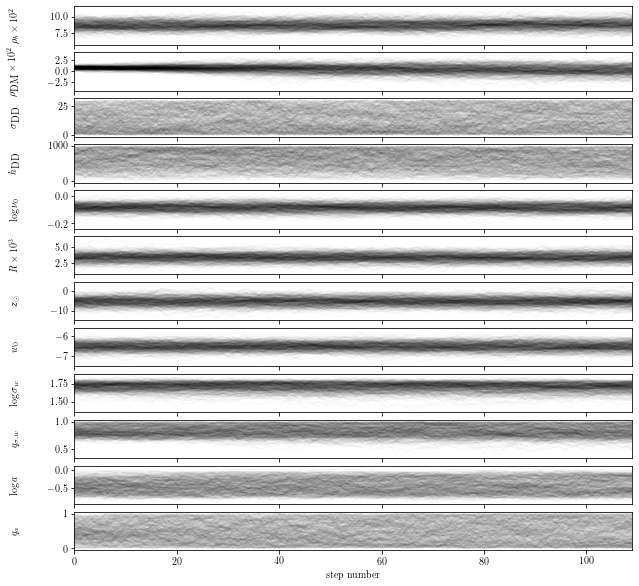

In [15]:
thin = 20
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\sigma_{\textup{DD}}$',
          r'$h_{\textup{DD}}$', r'$\log \nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'sigmaDD', 'hDD', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 
        'q_sigmaw', 'log_a', 'q_a']
indexes = [12] + list(range(24, len(labs)+23))

params = get_params(chain[::thin], indexes, labs)
plot_chain(params, labels, figsize=(10,10), alpha=0.02)

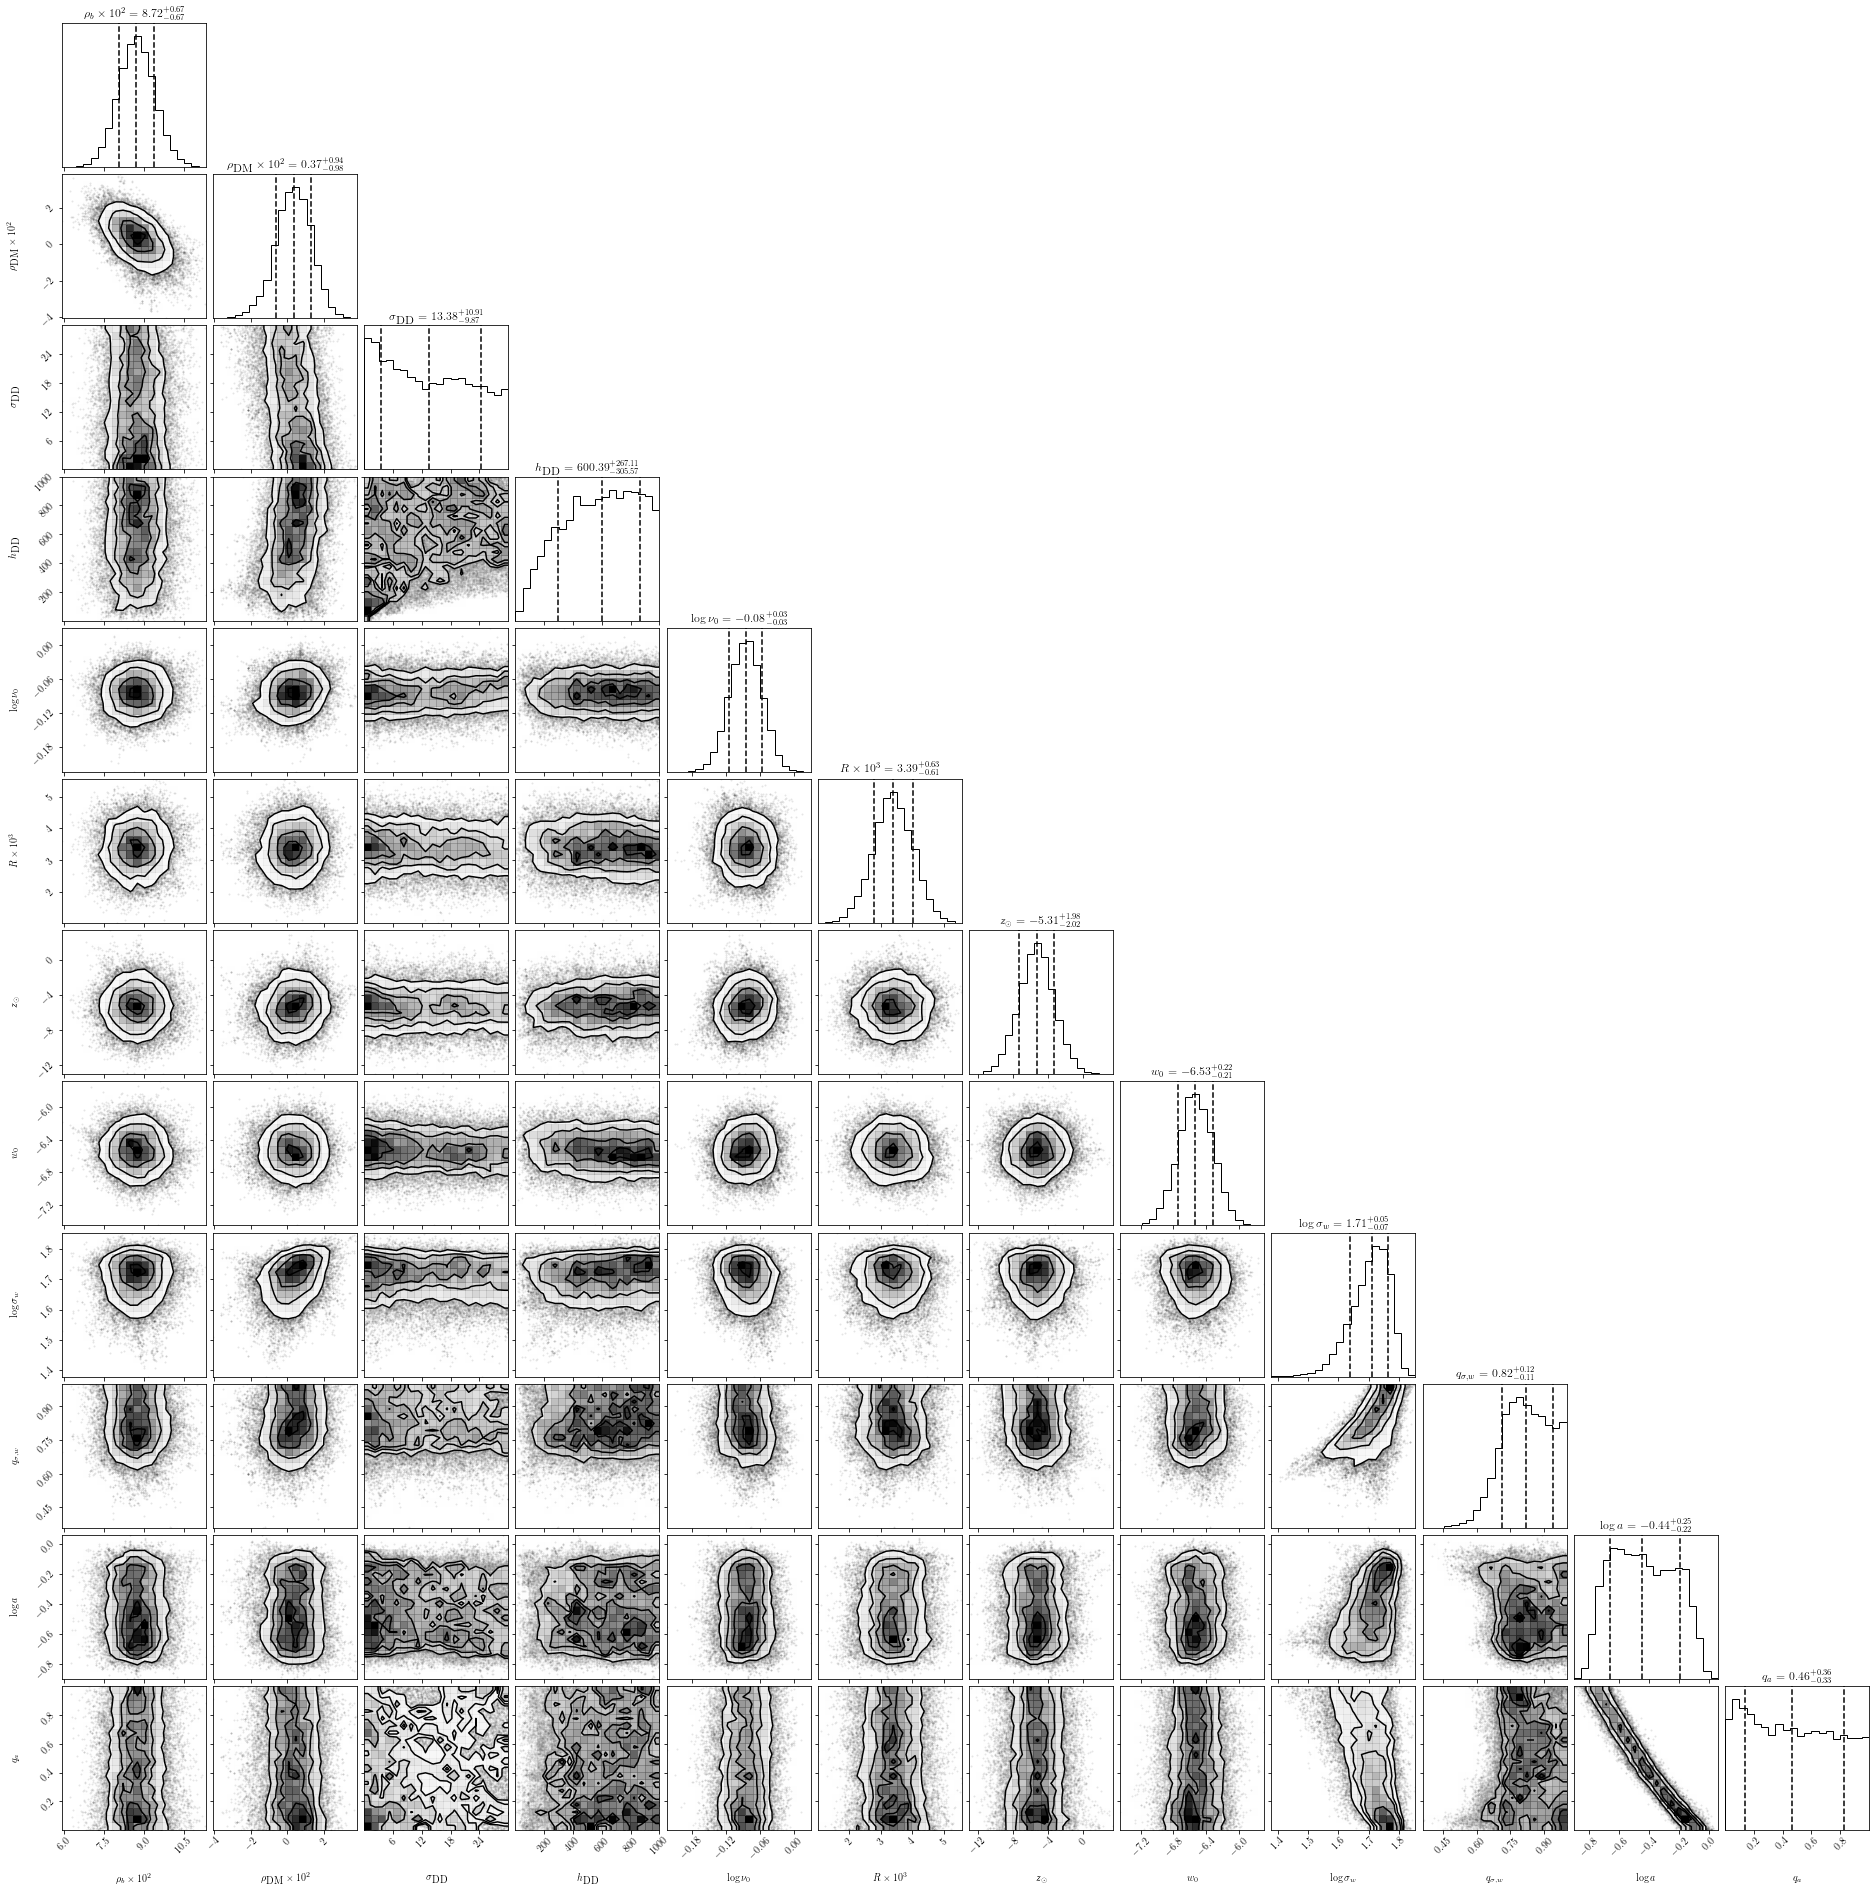

In [16]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r'$\sigma_{\textup{DD}}$',
          r'$h_{\textup{DD}}$', r'$\log \nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', 
          r'$\log \sigma_{w}$', r'$q_{\sigma,w}$', r'$\log a$', r'$q_a$']
labs = ['rhob', 'rhoDM', 'sigmaDD', 'hDD', 'log_nu0', 'R', 'zsun', 'w0', 'log_sigmaw', 
        'q_sigmaw', 'log_a', 'q_a']
indexes = [12] + list(range(24, len(labs)+23))
chain_thin = chain[::thin]

params = get_params(chain_thin[40:], indexes, labs)
plot_corner(params, labels)

(774400, 35)


100%|██████████| 5000/5000 [00:03<00:00, 1400.25it/s]


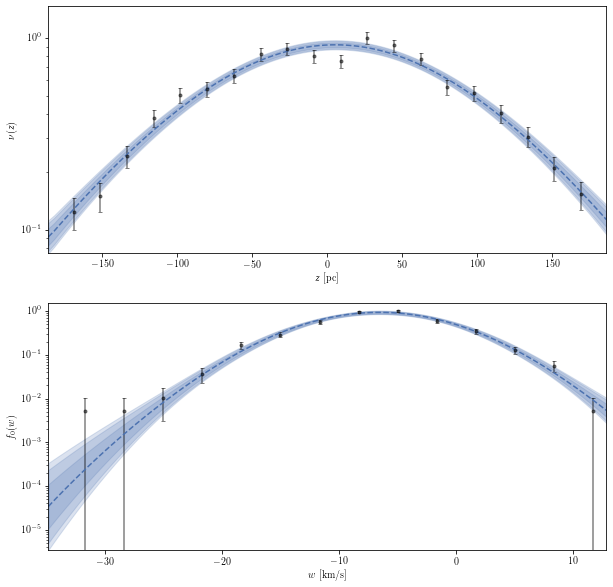

In [17]:
plot_fit(dddm, zdata, wdata, chain, ndim)

In [24]:
probs = calculate_probs(dddm, chain, ndim, zdata, wdata, locs, scales)

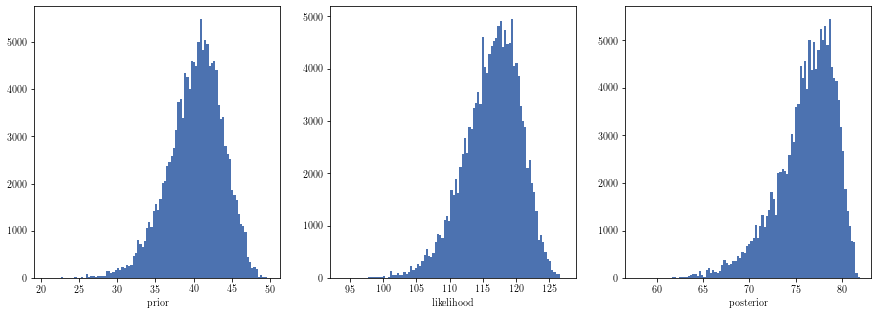

127.28234144201754

In [25]:
prior = probs[:, 0]
likelihood = probs[:, 2]
posterior = probs[:, 1]
# plot histogram of probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(prior, bins=100)
axes[0].set_xlabel('prior')
axes[1].hist(likelihood, bins=100)
axes[1].set_xlabel('likelihood')
axes[2].hist(posterior, bins=100)
axes[2].set_xlabel('posterior')
plt.show()
likelihood.max()

# educated initial guess!?!

check 1_mock_dm

# Script

do mcmc for

* same $N$, different $z$
* same $z$, different $N$

Each 'running' contains
1. generate_init: initial position for walkers.
    * this is done by the experiment above.
2. run_mcmc: run true mcmc for 10_000 steps.
3. plot trace: plot trace plot for preliminary mcmc.
4. plot corner: plot corner plot for the long run.
5. plot fit: fitting plot for vertical density and vertical dispersion.
6. calculate bic & aic: calculate bic and aic for the long run.

All of these functionalities are implemented in `mcmc.py` at `utils`.

Just run the `program.py` at `script`.
To automate the process for all data, run `run_program.py` at `script`.

# Mock comparison

run mcmc but now for mock data comparison.

`Data/MCMC/dm_mock/mock/comp`

It contains mock data with different number of data points.
1000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000

This comparison is done to see the prediction power of the model.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join
import sys
from glob import glob
import vaex
from hammer import dddm
root_dir = abspath(join('..', '..'))
data_dir = join(root_dir, 'Data')
sys.path.append(root_dir)

In [15]:
from utils import style, calculate_probs, plot_chain, plot_corner, plot_fit, get_params

style()

In [3]:
zfiles = glob(join(root_dir, 'Data', 'MCMC', 'dm_mock', 'mock', 'comp', 'z*.hdf5'))
zfiles.sort()
wfiles = glob(join(root_dir, 'Data', 'MCMC', 'dm_mock', 'mock', 'comp','w*.hdf5'))
wfiles.sort()
zfiles, wfiles

(['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_1000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_10000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_100000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_1000000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_5000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_50000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/z_500000.hdf5'],
 ['/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_1000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_10000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_100000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_1000000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/comp/w_5000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC/dm_mock/mock/co

In [4]:
index = 0
zfile = zfiles[index]
wfile = wfiles[index]
zdata = vaex.open(zfile)
zmid = zdata['zmid'].to_numpy()
znum = zdata['znum'].to_numpy()
zerr = zdata['zerr'].to_numpy()

wdata = vaex.open(wfile)
wmid = wdata['wmid'].to_numpy()
wnum = wdata['wnum'].to_numpy()
werr = wdata['werr'].to_numpy()

zdata = (zmid, znum, zerr)
wdata = (wmid, wnum, werr)

In [6]:
rhob = [
    0.0104, 0.0277, 0.0073, 0.0005, 0.0006, 0.0018,
    0.0018, 0.0029, 0.0072, 0.0216, 0.0056, 0.0015
]
sigmaz = [
    3.7, 7.1, 22.1, 39.0, 15.5, 7.5, 12.0, 
    18.0, 18.5, 18.5, 20.0, 20.0]
rhoDM = [0.016]
sigmaDD = [7]
log_hDD = [np.log(30)]
log_nu0 = [0]
R = [3.4E-3]
zsun = [30]
w0 = [-7.]
log_sigmaw1 = [np.log(5.)]
log_a1 = [np.log(0.5)]
log_sigmaw2 = [np.log(10.)]
log_a2 = [np.log(0.1)]

theta = np.array([rhob + sigmaz + rhoDM + sigmaDD + log_hDD + log_nu0 + R + zsun+w0 + log_sigmaw1 + log_a1 + log_sigmaw2 + log_a2]).flatten()
theta.shape

(35,)

In [7]:
locs = dict(
    rhoDM=-0.05,
    sigmaDD=0.1,
    log_hDD=np.log(1),
    log_nu0=-1,
    R=3.4E-3,
    zsun=-50,
    w0=-15,
    log_sigmaw1=np.log(1),
    log_a1=np.log(0.05),
    log_sigmaw2=np.log(1),
    log_a2=np.log(0.05),
)

scales = dict(
    rhoDM=0.15,
    sigmaDD=30,
    log_hDD=np.log(100)-locs['log_hDD'],
    log_nu0=3,
    R=0.6E-3,
    zsun=100,
    w0=15,
    log_sigmaw1=np.log(25)-locs['log_sigmaw1'],
    log_a1=np.log(2)-locs['log_a1'],
    log_sigmaw2=np.log(25)-locs['log_sigmaw2'],
    log_a2=np.log(2)-locs['log_a2'],
)

keys = list(locs.keys())
locs = np.array(list(locs.values()))
scales = np.array(list(scales.values()))

[(k, loc, th, s+loc) for k, loc, th, s in zip(keys, locs, theta[24:], scales)]

[('rhoDM', -0.05, 0.016, 0.09999999999999999),
 ('sigmaDD', 0.1, 7.0, 30.1),
 ('log_hDD', 0.0, 3.4011973816621555, 4.605170185988092),
 ('log_nu0', -1.0, 0.0, 2.0),
 ('R', 0.0034, 0.0034, 0.004),
 ('zsun', -50.0, 30.0, 50.0),
 ('w0', -15.0, -7.0, 0.0),
 ('log_sigmaw1', 0.0, 1.6094379124341003, 3.2188758248682006),
 ('log_a1', -2.995732273553991, -0.6931471805599453, 0.6931471805599454),
 ('log_sigmaw2', 0.0, 2.302585092994046, 3.2188758248682006),
 ('log_a2', -2.995732273553991, -2.3025850929940455, 0.6931471805599454)]

(35,)


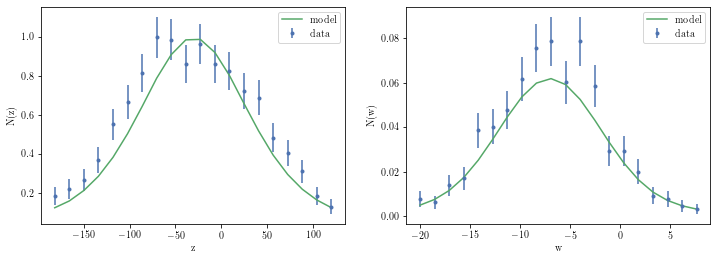

(51.60009219664631, 142.02357927126934)

In [8]:
print(theta.shape)
zmod = dddm.fz(zmid, theta)
wmod = dddm.fw(wmid, theta)

# plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].errorbar(zmid, znum, yerr=zerr, fmt='.', label='data')
ax[0].plot(zmid, zmod, label='model')
ax[0].set_xlabel('z')
ax[0].set_ylabel('N(z)')
ax[0].legend()
ax[1].errorbar(wmid, wnum, yerr=werr, fmt='.', label='data')
ax[1].plot(wmid, wmod, label='model')
ax[1].set_xlabel('w')
ax[1].set_ylabel('N(w)')
ax[1].legend()
plt.show()
dddm.log_prob(theta, zdata, wdata, locs, scales)

In [9]:
ndim = len(locs)+24
nwalkers = 2*ndim+2
ndim, nwalkers

(35, 72)

In [10]:
p0 = dddm.generate_p0(nwalkers, locs, scales, kind=2)
p0.shape

(72, 35)

In [11]:
p0_flat = p0.reshape(-1, ndim)
dddm.log_prob_par(p0_flat, zdata, wdata, locs, scales)

array([[ 4.34744695e+01, -1.03063859e+03, -9.87164117e+02],
       [ 4.26104693e+01, -3.75659042e+02, -3.33048573e+02],
       [ 3.51788396e+01, -7.05781212e+03, -7.02263328e+03],
       [ 4.46871218e+01, -5.39391214e+02, -4.94704092e+02],
       [ 4.43133628e+01, -2.28883902e+03, -2.24452566e+03],
       [ 4.05914353e+01, -1.42994828e+03, -1.38935685e+03],
       [ 3.80349543e+01, -1.47107161e+02, -1.09072206e+02],
       [ 4.22482920e+01, -2.63822829e+02, -2.21574537e+02],
       [ 3.54708842e+01, -2.31135246e+04, -2.30780537e+04],
       [ 4.19520926e+01, -1.03807731e+03, -9.96125221e+02],
       [ 4.46438530e+01, -2.10435484e+02, -1.65791632e+02],
       [ 3.53234881e+01, -4.22334990e+03, -4.18802641e+03],
       [ 4.15308345e+01, -1.01778666e+04, -1.01363357e+04],
       [ 4.14061593e+01, -8.59980916e+03, -8.55840300e+03],
       [ 4.33281224e+01, -2.73289913e+03, -2.68957101e+03],
       [ 4.08087694e+01, -8.17787330e+03, -8.13706453e+03],
       [ 4.09950456e+01, -1.61735344e+03

In [12]:
t0 = time()
chain = dddm.mcmc(500, nwalkers, p0, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

11.502993822097778 s


(500, 72, 35)

In [13]:
calculate_probs(dddm, chain, ndim, zdata, wdata, locs, scales, batch=100)

array([[   44.57174918,  -759.3396411 ,  -714.76789192],
       [   42.61046932,  -375.65904243,  -333.04857311],
       [   35.17883963, -7057.81211632, -7022.63327669],
       ...,
       [   45.5281166 ,   101.75112554,   147.27924215],
       [   46.14243919,    99.84962405,   145.99206324],
       [   40.5243795 ,    94.26271193,   134.78709144]])

In [28]:
def get_params(chain, indexes, labs):
    params = []
    dic = {key: value for key, value in zip(labs, indexes)}
    for l, i in dic.items():
        if l == 'rhob':
            params.append(chain[:, :, :i].sum(axis=2).T/1E-2)
        elif l == 'rhoDM':
            params.append(chain[:, :, i].T/1E-2)
        elif l == 'R':
            params.append(chain[:, :, i].T/1E-3)
        else:
            params.append(chain[:, :, i].T)
    params = np.array(params).T
    return params

100%|██████████| 12/12 [00:00<00:00, 19.37it/s]


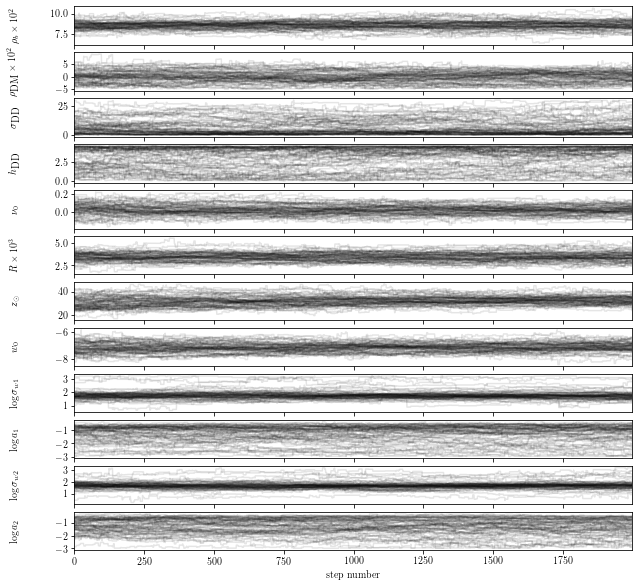

In [31]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r"$\sigma_{\textup{DD}}$", r"$h_{\textup{DD}}$", r'$\nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_{w1}$', r'$\log a_1$', r'$\log \sigma_{w2}$', r'$\log a_2$']
labs = ['rhob', 'rhoDM', 'sigmaDD', 'hDD', 'nu0', 'R', 'zsun', 'w0', 'log_sigmaw1', 'log_a1', 'log_sigmaw2', 'log_a2']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10))

In [17]:
p0_next = chain[-1, :, :]
t0 = time()
chain = dddm.mcmc(2000, nwalkers, p0_next, zdata, wdata, locs, scales, dz=1, verbose=True, parallel=True)
print(time() - t0, "s")
chain.shape

32.21579337120056 s


(2000, 72, 35)

100%|██████████| 12/12 [00:00<00:00, 21.35it/s]


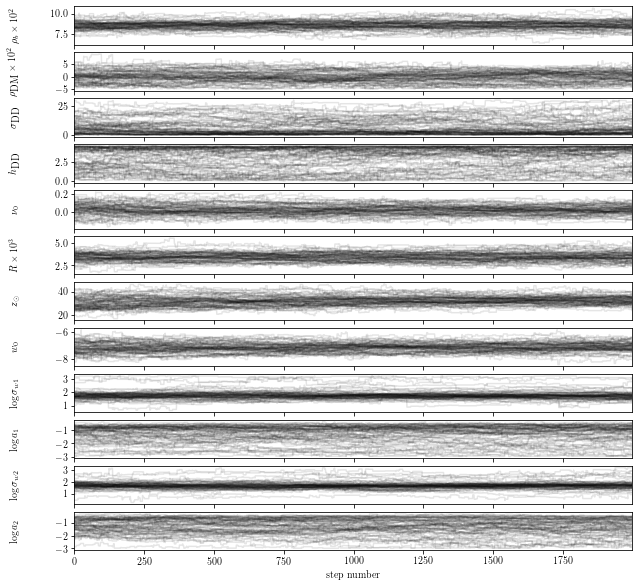

In [32]:
labels = [r'$\rho_b\times 10^2$', r'$\rho_{\textup{DM}}\times 10^2$', r"$\sigma_{\textup{DD}}$", r"$h_{\textup{DD}}$", r'$\nu_0$', r'$R\times 10^3$', r'$z_{\odot}$', r'$w_0$', r'$\log \sigma_{w1}$', r'$\log a_1$', r'$\log \sigma_{w2}$', r'$\log a_2$']
labs = ['rhob', 'rhoDM', 'sigmaDD', 'hDD', 'nu0', 'R', 'zsun', 'w0', 'log_sigmaw1', 'log_a1', 'log_sigmaw2', 'log_a2']
indexes = [12, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

params = get_params(chain, indexes, labs)
plot_chain(params, labels, figsize=(10,10))

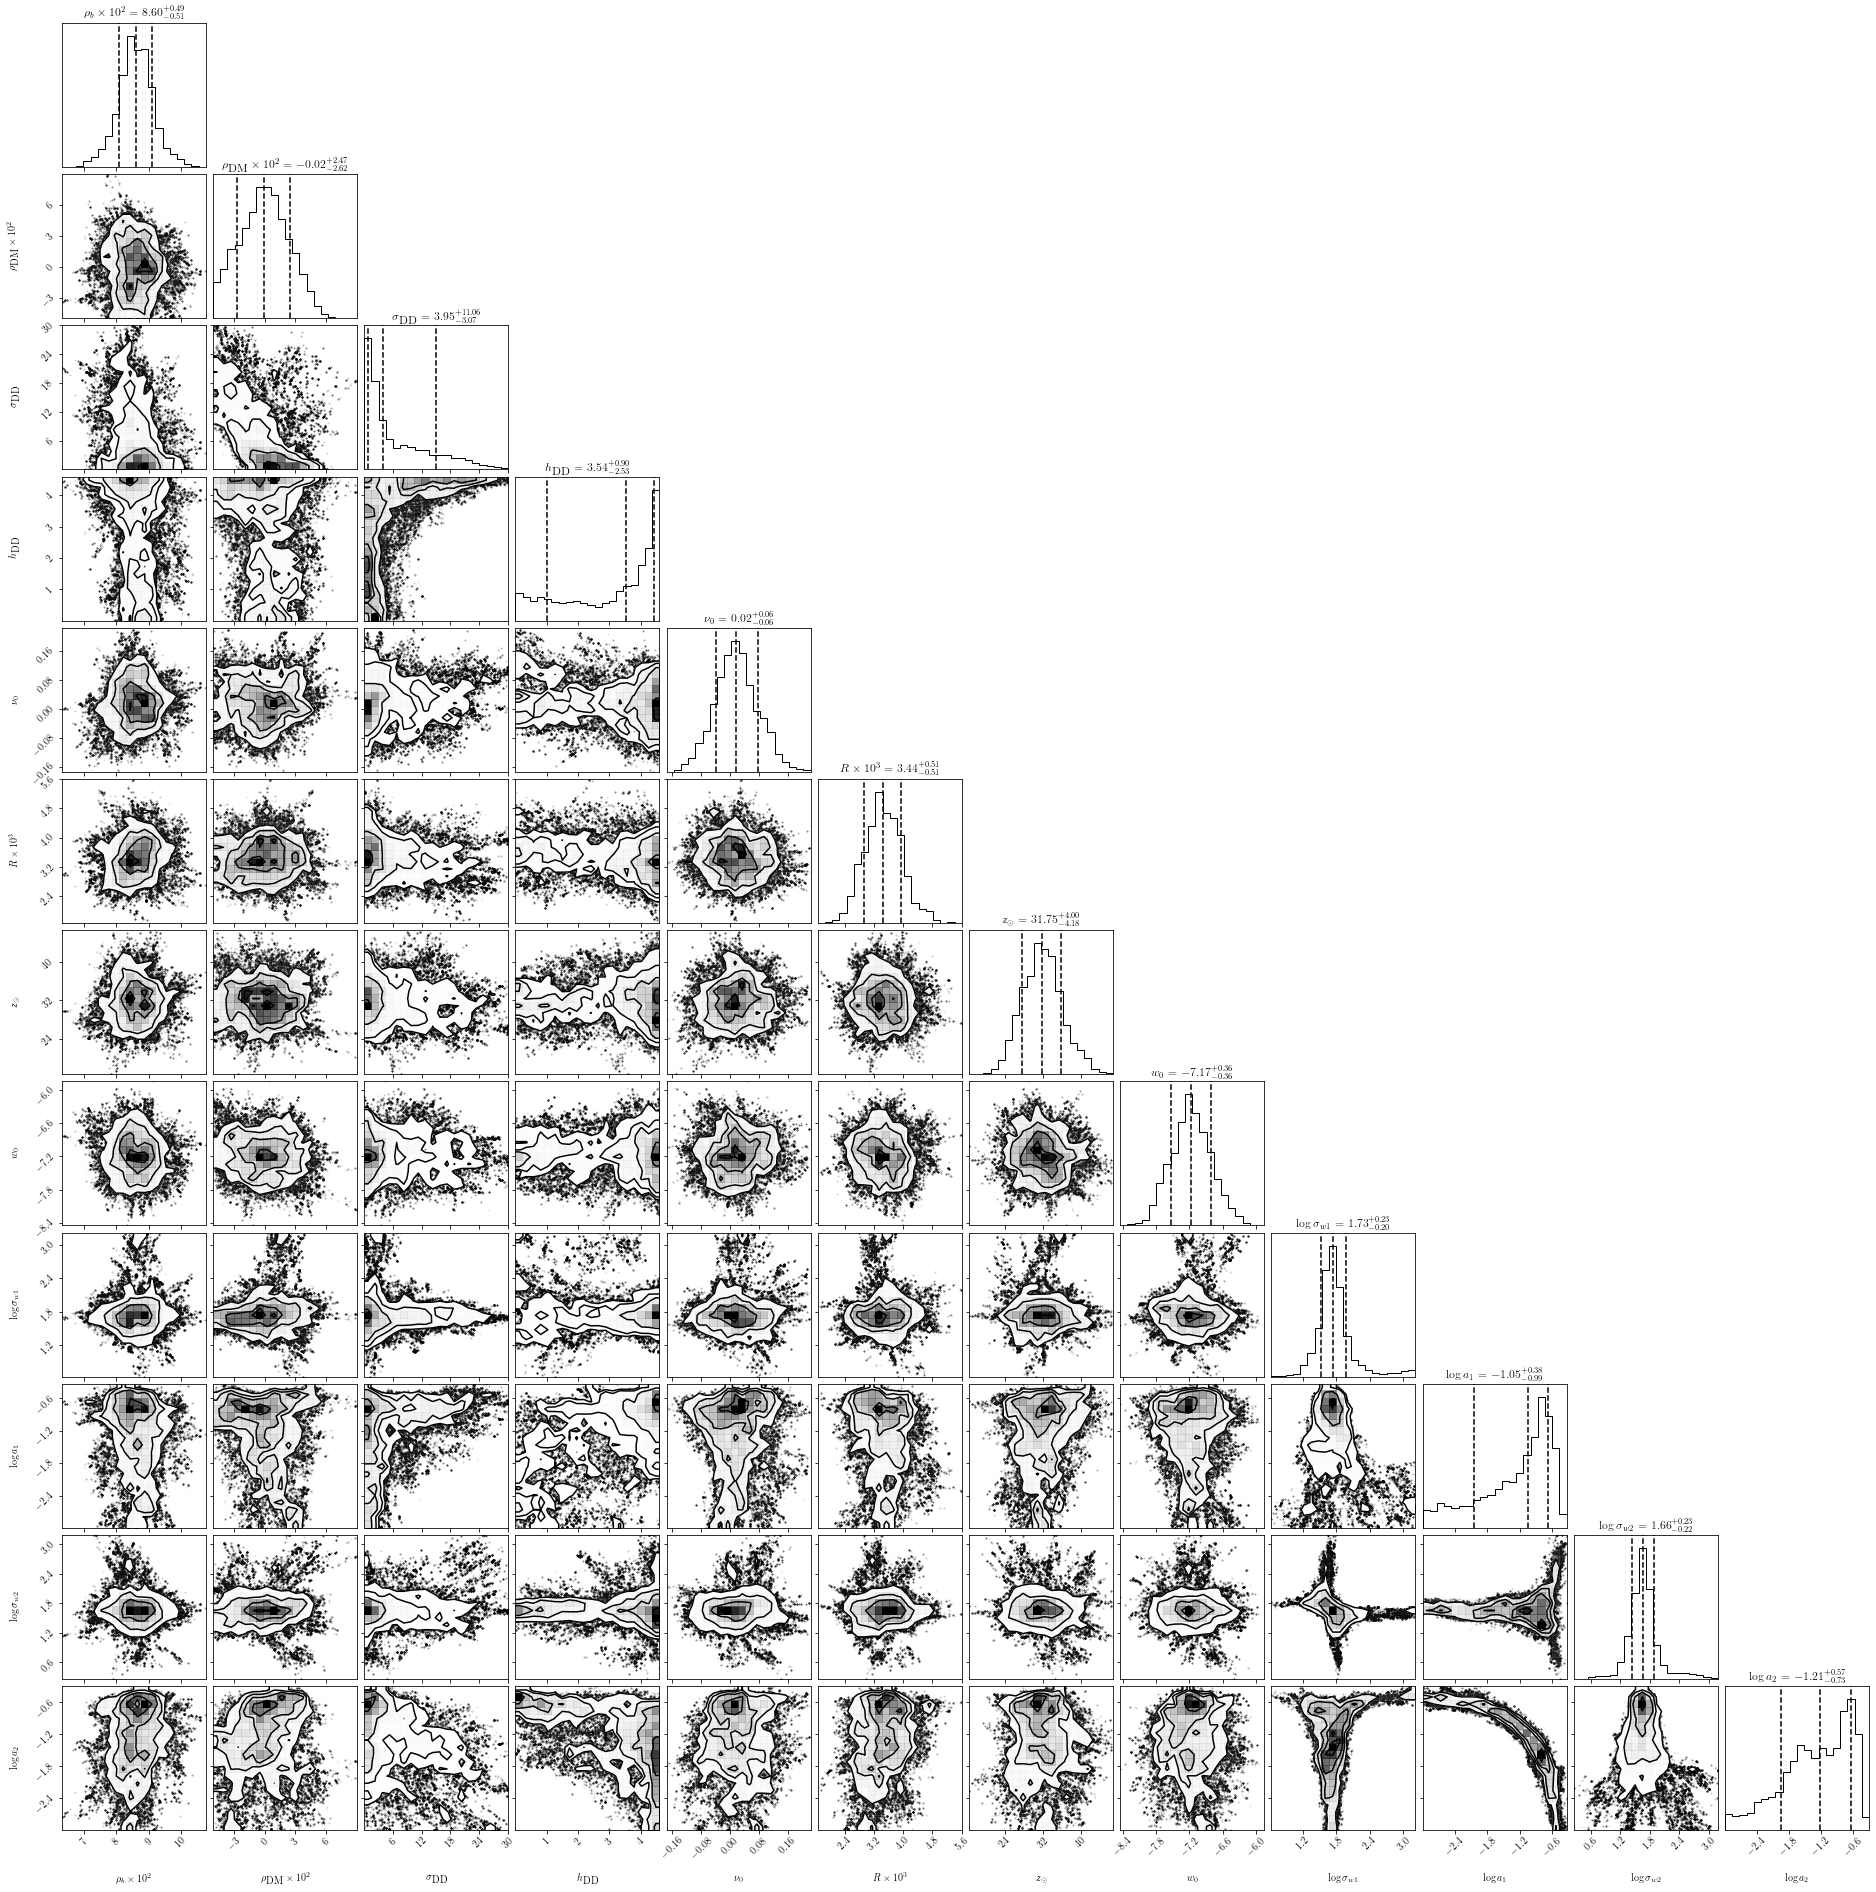

In [33]:
plot_corner(params, labels)

(144000, 35)


100%|██████████| 50000/50000 [01:10<00:00, 712.74it/s]


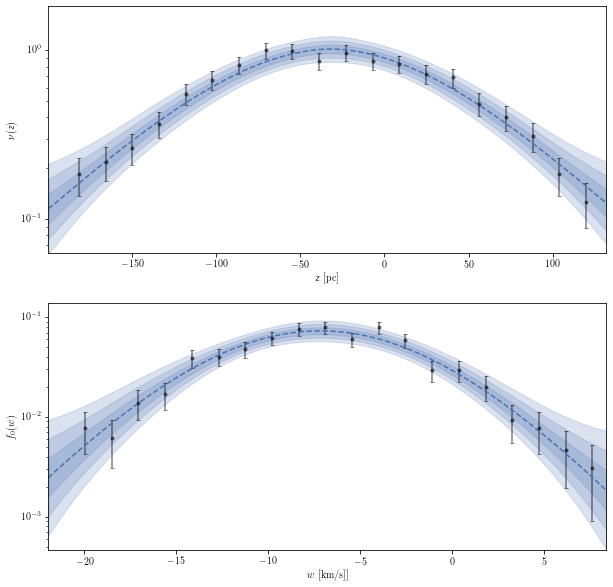

In [34]:
plot_fit(dddm, zdata, wdata, chain, ndim)

In [39]:
probs = calculate_probs(dddm, chain, ndim, zdata, wdata, locs, scales)

In [ ]:
prior = probs[:, 0]
likelihood = probs[:, 2]
posterior = probs[:, 1]
# plot histogram of probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(prior, bins=100)
axes[0].set_xlabel('prior')
axes[1].hist(likelihood, bins=100)
axes[1].set_xlabel('likelihood')
axes[2].hist(posterior, bins=100)
axes[2].set_xlabel('posterior')
plt.show()
likelihood.max()

The script for comparing also implemented in `script` folder.